In [1]:
import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import layer_utils, to_categorical, plot_model
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.preprocessing import image
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras import regularizers

from IPython.display import SVG
import matplotlib.pyplot as plt
from scipy import ndimage, misc

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.utils.multiclass import unique_labels


Using TensorFlow backend.


In [2]:
df=pd.read_pickle("./input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


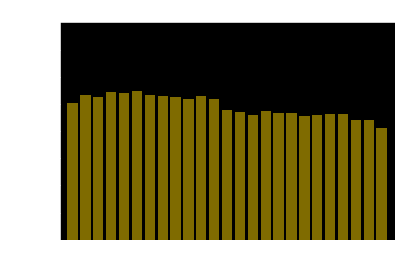

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [6]:
df = df.drop(['waferIndex'], axis = 1)

In [7]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
515360,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot32189,[],[],"(25, 27)"
71665,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot5383,[],[],"(33, 33)"
119598,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3030.0,lot8042,[],[],"(54, 71)"
473144,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29143,[],[],"(49, 39)"
478458,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29595,[],[],"(49, 39)"


In [8]:
Wdim = np.unique(df['waferMapDim'])

In [9]:
cnt = np.zeros(Wdim.size)
c_maxdim = 0

for i in range(Wdim.size):
    sdf = df.loc[df['waferMapDim'] == Wdim[i]]
    cnt[i] = 0

    for j in range(len(sdf)):
    # skip null label
        if len(sdf.iloc[j,:]['failureType']) == 0:
            continue
        cnt[i] += 1

    if cnt[i] > c_maxdim:
        c_maxdim = cnt[i]
        c_index = i

print(c_maxdim)
print(Wdim[c_index])

18781.0
(25, 27)


In [10]:
cnt = np.zeros(Wdim.size)
c_maxdim = 0

for i in range(Wdim.size):
    sdf = df.loc[df['waferMapDim'] == Wdim[i]]
    cnt[i] = 0

    for j in range(len(sdf)):
    # skip null label
        if len(sdf.iloc[j,:]['failureType']) == 0:
            continue
        cnt[i] += 1

    if cnt[i] == 10682.0:
        c_maxdim = cnt[i]
        c_index = i
        break

print(c_maxdim)
print(Wdim[c_index])

10682.0
(27, 25)


In [9]:
sub_df = df.loc[df['waferMapDim'] == (25, 27)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 25, 27))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 25, 27)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [10]:
x1 = sw[1:]
x = np.pad(x1, ((0,0),(1,1),(0,0)), mode='constant', constant_values = (0,0))
y = np.array(label).reshape((-1,1))

In [11]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (18781, 27, 27), y shape : (18781, 1)


In [12]:
sub_df1 = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer1 = sub_df1['waferMap'].values

sw1 = np.ones((1, 26, 26))
label1 = list()

for i in range(len(sub_df1)):
    # skip null label
    if len(sub_df1.iloc[i,:]['failureType']) == 0:
        continue
    sw1 = np.concatenate((sw1, sub_df1.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label1.append(sub_df1.iloc[i,:]['failureType'][0][0])

In [13]:
x2 = sw1[1:]
x3 = np.pad(x2, ((0,0),(1,0),(1,0)), mode='constant', constant_values = (0,0))
y2 = np.array(label1).reshape((-1,1))

In [14]:
print('x3 shape : {}, y2 shape : {}'.format(x3.shape, y2.shape))

x3 shape : (14366, 27, 27), y2 shape : (14366, 1)


In [15]:
sub_df2 = df.loc[df['waferMapDim'] == (27, 25)]
sub_wafer2 = sub_df2['waferMap'].values

sw2 = np.ones((1, 27, 25))
label2= list()

for i in range(len(sub_df2)):
    # skip null label
    if len(sub_df2.iloc[i,:]['failureType']) == 0:
        continue
    sw2 = np.concatenate((sw2, sub_df2.iloc[i,:]['waferMap'].reshape(1, 27, 25)))
    label2.append(sub_df2.iloc[i,:]['failureType'][0][0])

In [16]:
x4 = sw2[1:]
x5 = np.pad(x4, ((0,0),(0,0),(1,1)), mode='constant', constant_values = (0,0))
y3 = np.array(label2).reshape((-1,1))

In [17]:
print('x5 shape : {}, y3 shape : {}'.format(x5.shape, y3.shape))

x5 shape : (10682, 27, 27), y3 shape : (10682, 1)


In [18]:
x3 = np.concatenate((x3, x5[0:]))
y2 = np.concatenate((y2, y3))

In [19]:
x = np.concatenate((x, x3[0:]))
y = np.concatenate((y, y2))

In [20]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (43829, 27, 27), y shape : (43829, 1)


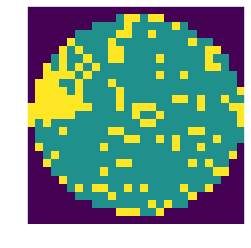

Faulty case : ['Edge-Loc'] 


In [21]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [22]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [23]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2364
Donut : 7
Edge-Loc : 747
Edge-Ring : 56
Loc : 573
Near-full : 48
Random : 137
Scratch : 102
none : 39795


In [24]:
Donut_idx = np.where(y=='Donut')[0][0]

In [25]:
rot_e30 = ndimage.rotate(x[Donut_idx], 30, axes=(0,1), mode='constant', order = 0, reshape=False)

In [26]:
rot_e45 = ndimage.rotate(x[Donut_idx], 45, axes=(0,1), mode='constant', order = 0, reshape=False)

In [27]:
rot_e90 = ndimage.rotate(x[Donut_idx], 90, axes=(0,1), mode='constant', order = 0, reshape=False)

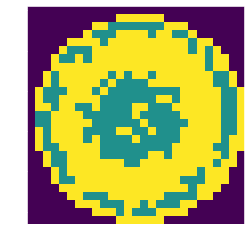

Faulty case : ['Donut'] 


In [28]:
# plot Donut fault data
plt.imshow(x[Donut_idx])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[Donut_idx]))

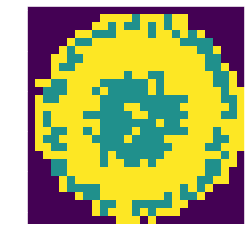

In [29]:
# plot 30 degree rotated Donut fault data
plt.imshow(rot_e30)
plt.show()

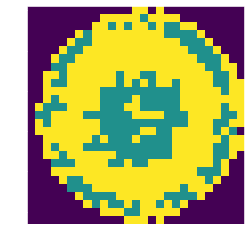

In [30]:
#plot 45 degree rotated Donut fault data
plt.imshow(rot_e45)
plt.show()

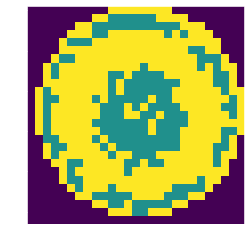

In [31]:
# plot 90 degree rotated Donut fault data
plt.imshow(rot_e90)
plt.show()

In [32]:
# choice index with y='none'(no defect) and delete choiced index data.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=34000, replace=False)]
new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [33]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (9829, 27, 27), new_y shape : (9829, 1)


In [34]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2364
Donut : 7
Edge-Loc : 747
Edge-Ring : 56
Loc : 573
Near-full : 48
Random : 137
Scratch : 102
none : 5795


In [35]:
#Before Data augmentation: Split the data with 8:2 ratio
x_train_temp, x_test, y_train_temp, y_test = train_test_split(new_x, new_y, test_size=0.3, random_state=7)

In [36]:
print('Train x : {}, y : {}'.format(x_train_temp.shape, y_train_temp.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (6880, 27, 27), y : (6880, 1)
Test x: (2949, 27, 27), y : (2949, 1)


In [37]:
#Before data augmentation : Train Data Distribution
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train_temp[y_train_temp==f])))

Center : 1670
Donut : 5
Edge-Loc : 498
Edge-Ring : 42
Loc : 419
Near-full : 31
Random : 91
Scratch : 74
none : 4050


In [38]:
#Test Data Distribution
for f in faulty_case :
    print('{} : {}'.format(f, len(y_test[y_test==f])))

Center : 694
Donut : 2
Edge-Loc : 249
Edge-Ring : 14
Loc : 154
Near-full : 17
Random : 46
Scratch : 28
none : 1745


In [39]:
#x_test : add channel
x_test = x_test.reshape((-1, 27, 27, 1))

In [40]:
#y_test : make string label data to numerical data
for i, l in enumerate(faulty_case):
    y_test[y_test==l] = i
    
# one-hot-encoding
y_test = to_categorical(y_test)

In [41]:
#Training Data augmentation by rotating
rot_X = np.ones((1, 27, 27))
r_x = np.ones((1, 27, 27))
y_label = list()

for i in range(len(faulty_case)):
    if(len(y_train_temp[y_train_temp==faulty_case[i]]) < 4000):
        for j in range(4000 - len(y_train_temp[y_train_temp==faulty_case[i]])):
            n = np.random.randint(len(y_train_temp[y_train_temp==faulty_case[i]]))
            r_x = ndimage.rotate(x_train_temp[np.where(y_train_temp==faulty_case[i])[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False)
            rot_X = np.concatenate((rot_X, r_x.reshape(1,27,27)))
            y_label.append(y_train_temp[y_train_temp==faulty_case[i]][0])

In [42]:
rx = rot_X[1:]
ry = np.array(y_label).reshape((-1,1))

In [43]:
x_train = np.concatenate((x_train_temp, rx[0:]))
y_train = np.concatenate((y_train_temp, ry))

In [44]:
faulty_case = np.unique(y_train)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [45]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

Center : 4000
Donut : 4000
Edge-Loc : 4000
Edge-Ring : 4000
Loc : 4000
Near-full : 4000
Random : 4000
Scratch : 4000
none : 4050


In [46]:
#x_train: add channel
x_train = x_train.reshape((-1, 27, 27, 1))

In [333]:
#check new x dimension
x_train.shape

(36050, 27, 27, 1)

In [48]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    y_train[y_train==l] = i
    
# one-hot-encoding
y_train = to_categorical(y_train)

In [516]:
# parameter
epoch=50
batch_size=800

In [517]:
def create_model():
    input_shape = (27, 27, 1)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_1)

    pool_1 = layers.MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.03), padding='same')(pool_1)
    conv_4 = layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.03), padding='same')(conv_3)

    #pool_2 = layers.MaxPool2D((2,2), name = 'max_pool2')(conv_4)

    flat = layers.Flatten()(conv_4)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(256, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
 
    return model

In [518]:
## Regualarization : L2 kernel_regularizer is added
## Result of experimental runs : The best result is shown in the case of conv_3, conv_4 have regularizer

W_model = create_model()

In [519]:
W_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [520]:
W_model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 27, 27, 1)         0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 27, 27, 16)        160       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 27, 27, 32)        4640      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 13, 13, 128)       73856     
_________________________________________________________________
flatten_23 (Flatten)         (None, 21632)             0  

In [521]:
Hist = W_model.fit(x_train, y_train, epochs=epoch, validation_data=[x_test, y_test], batch_size=batch_size)

Train on 36050 samples, validate on 2949 samples
Epoch 1/50
36050/36050 [==============================] - 4s 122us/step - loss: 3.4394 - accuracy: 0.4464 - val_loss: 2.1303 - val_accuracy: 0.5415
Epoch 2/50
36050/36050 [==============================] - 3s 80us/step - loss: 1.4280 - accuracy: 0.6981 - val_loss: 1.0910 - val_accuracy: 0.8372
Epoch 3/50
36050/36050 [==============================] - 3s 80us/step - loss: 1.0499 - accuracy: 0.7568 - val_loss: 0.8740 - val_accuracy: 0.8559
Epoch 4/50
36050/36050 [==============================] - 3s 81us/step - loss: 0.8680 - accuracy: 0.7862 - val_loss: 0.7469 - val_accuracy: 0.8691
Epoch 5/50
36050/36050 [==============================] - 3s 80us/step - loss: 0.7683 - accuracy: 0.8048 - val_loss: 0.7429 - val_accuracy: 0.8396
Epoch 6/50
36050/36050 [==============================] - 3s 80us/step - loss: 0.7042 - accuracy: 0.8162 - val_loss: 0.9506 - val_accuracy: 0.7141
Epoch 7/50
36050/36050 [==============================] - 3s 80us/st

In [522]:
### START CODE HERE ### (1 line)
pred = W_model.evaluate(x = x_test, y = y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(pred[0]))
print ("Test Accuracy = " + str(pred[1]))

2949/2949 [==============================] - 1s 228us/step

Loss = 0.2830375942684869
Test Accuracy = 0.9362495541572571


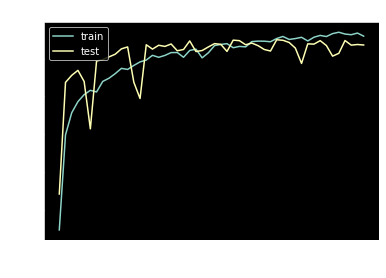

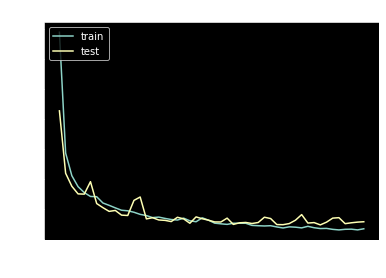

In [523]:
# accuracy plot 
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [524]:
y_pred = W_model.predict(x_test)

In [525]:
y_test_decode = np.ones(len(y_test))
y_pred_decode = np.ones(len(y_pred))

for i in range(len(y_pred)):
    y_pred_decode[i] = np.argmax(y_pred[i])
    y_test_decode[i] = np.argmax(y_test[i])

In [526]:
mis_index = np.where(y_pred_decode != y_test_decode)

Confusion matrix, without normalization
[[ 678    0    1    0    3    0    0    0   12]
 [   0    2    0    0    0    0    0    0    0]
 [   3    0  174   23   10    0    5    0   34]
 [   0    0    1   13    0    0    0    0    0]
 [   4    1    8    0  112    0    0    2   27]
 [   0    0    0    0    0   17    0    0    0]
 [   0    0    2    0    1    0   43    0    0]
 [   0    0    0    0    6    0    0    5   17]
 [   0    0    3    4   14    0    1    6 1717]]
Normalized confusion matrix
[[9.77e-01 0.00e+00 1.44e-03 0.00e+00 4.32e-03 0.00e+00 0.00e+00 0.00e+00
  1.73e-02]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [1.20e-02 0.00e+00 6.99e-01 9.24e-02 4.02e-02 0.00e+00 2.01e-02 0.00e+00
  1.37e-01]
 [0.00e+00 0.00e+00 7.14e-02 9.29e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [2.60e-02 6.49e-03 5.19e-02 0.00e+00 7.27e-01 0.00e+00 0.00e+00 1.30e-02
  1.75e-01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00

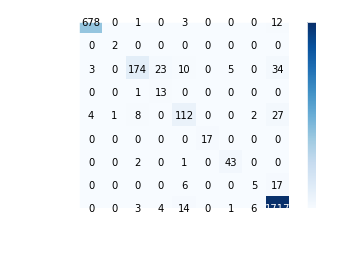

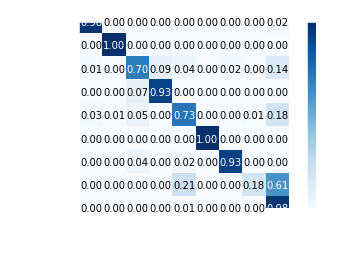

In [527]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_decode, y_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_decode, y_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [528]:
## Error Analysis

In [529]:
#remove channel
px_test = x_test[:,:,:,0]

In [530]:
# number of misclassified 
len(mis_index[0])

188

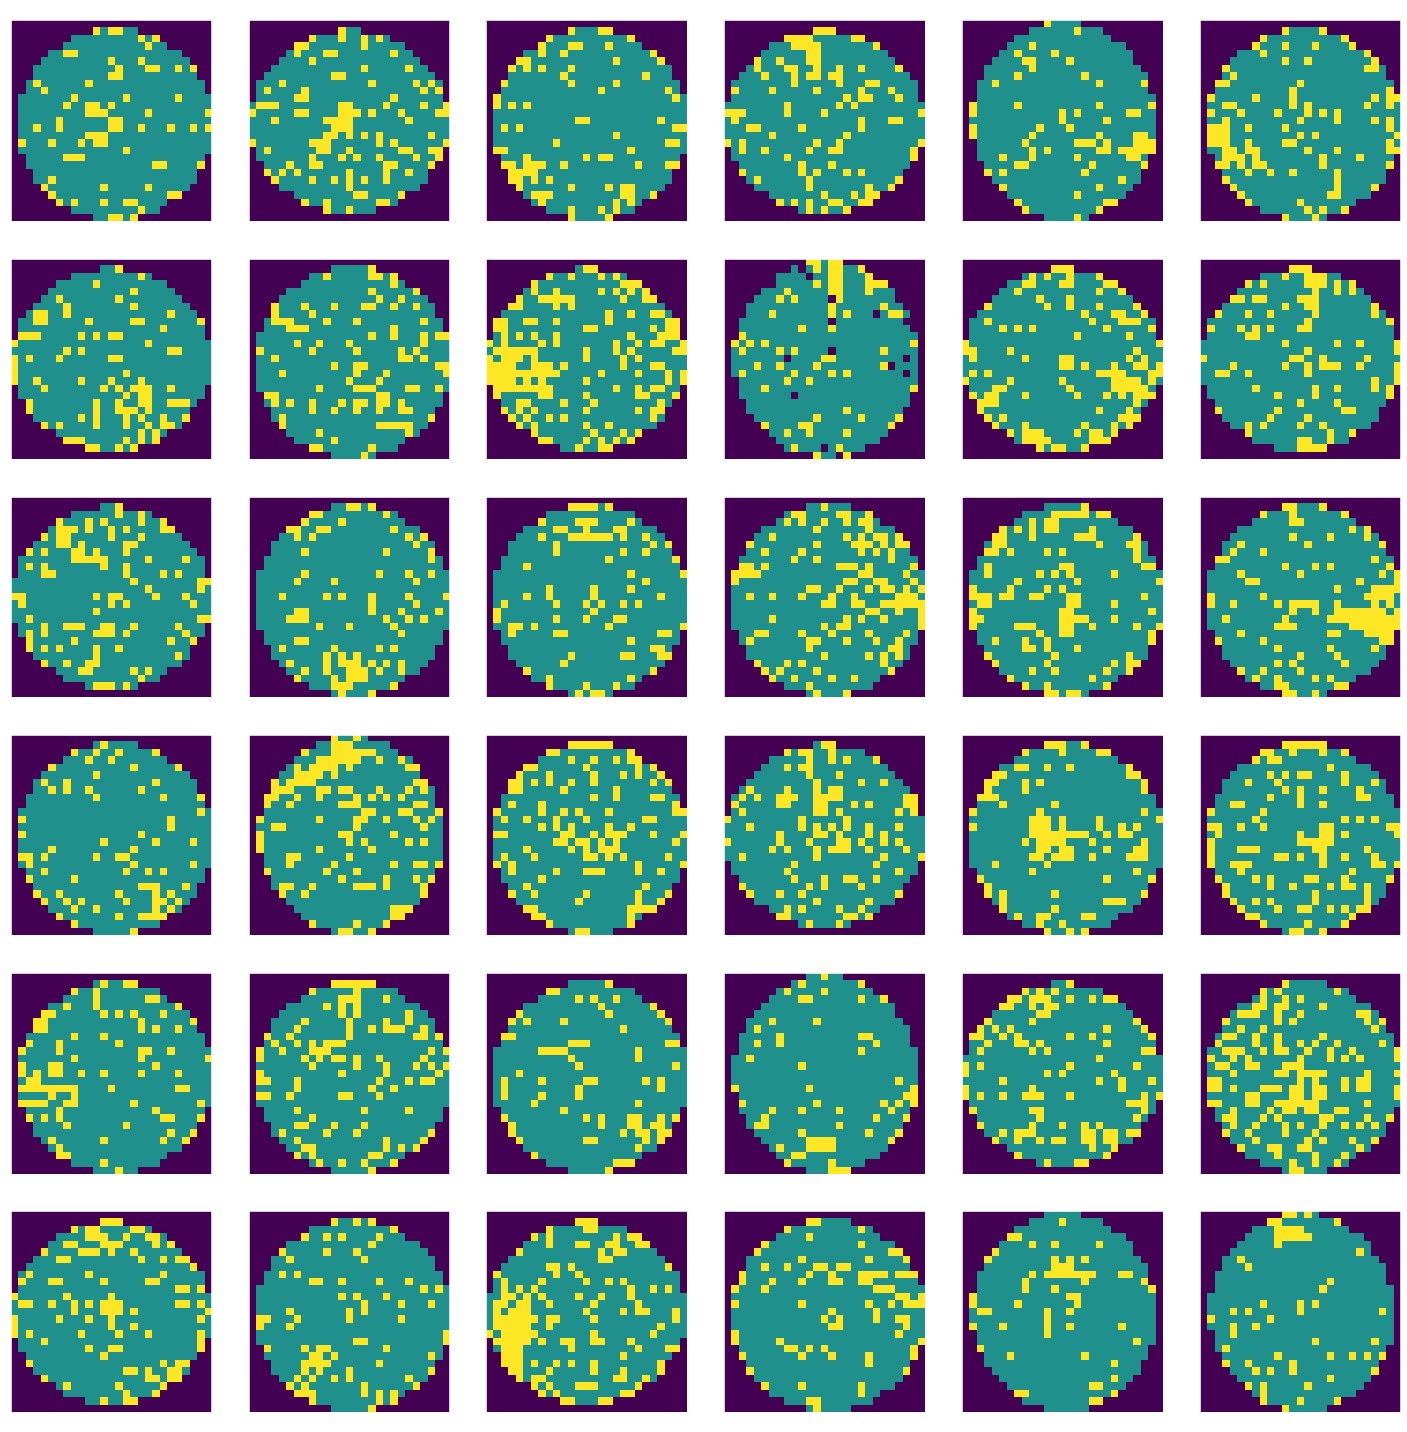

In [531]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(mis_index[0])):
        if faulty_case[int(y_test_decode[mis_index[0][i]])] == 'Loc':
            img = px_test[mis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {}'.format(faulty_case[int(y_pred_decode[mis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(y_test_decode[mis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

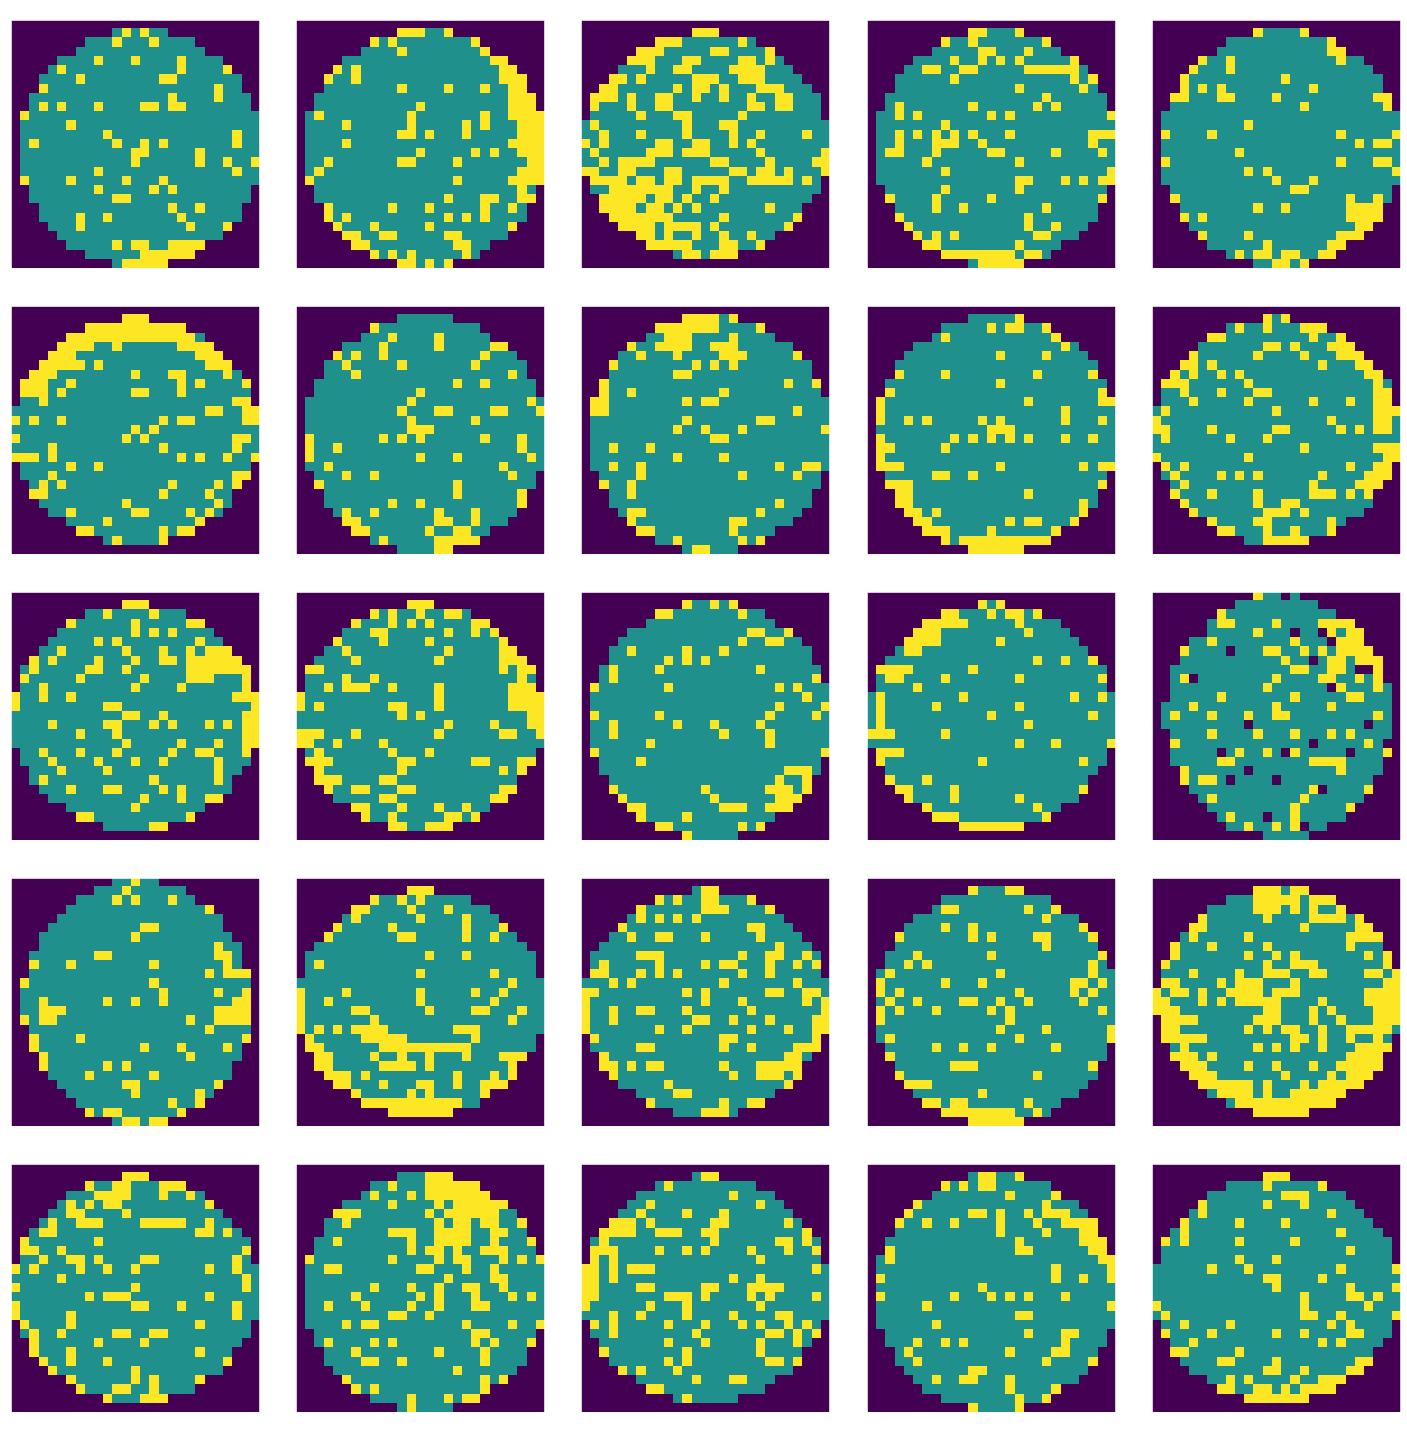

In [532]:
#Draw misclassified image
#Edge-Loc (local)
cnt = 0
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(mis_index[0])):
        if faulty_case[int(y_test_decode[mis_index[0][i]])] == 'Edge-Loc':
            img = px_test[mis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {}'.format(faulty_case[int(y_pred_decode[mis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(y_test_decode[mis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 25:
            break
plt.tight_layout()
plt.show() 

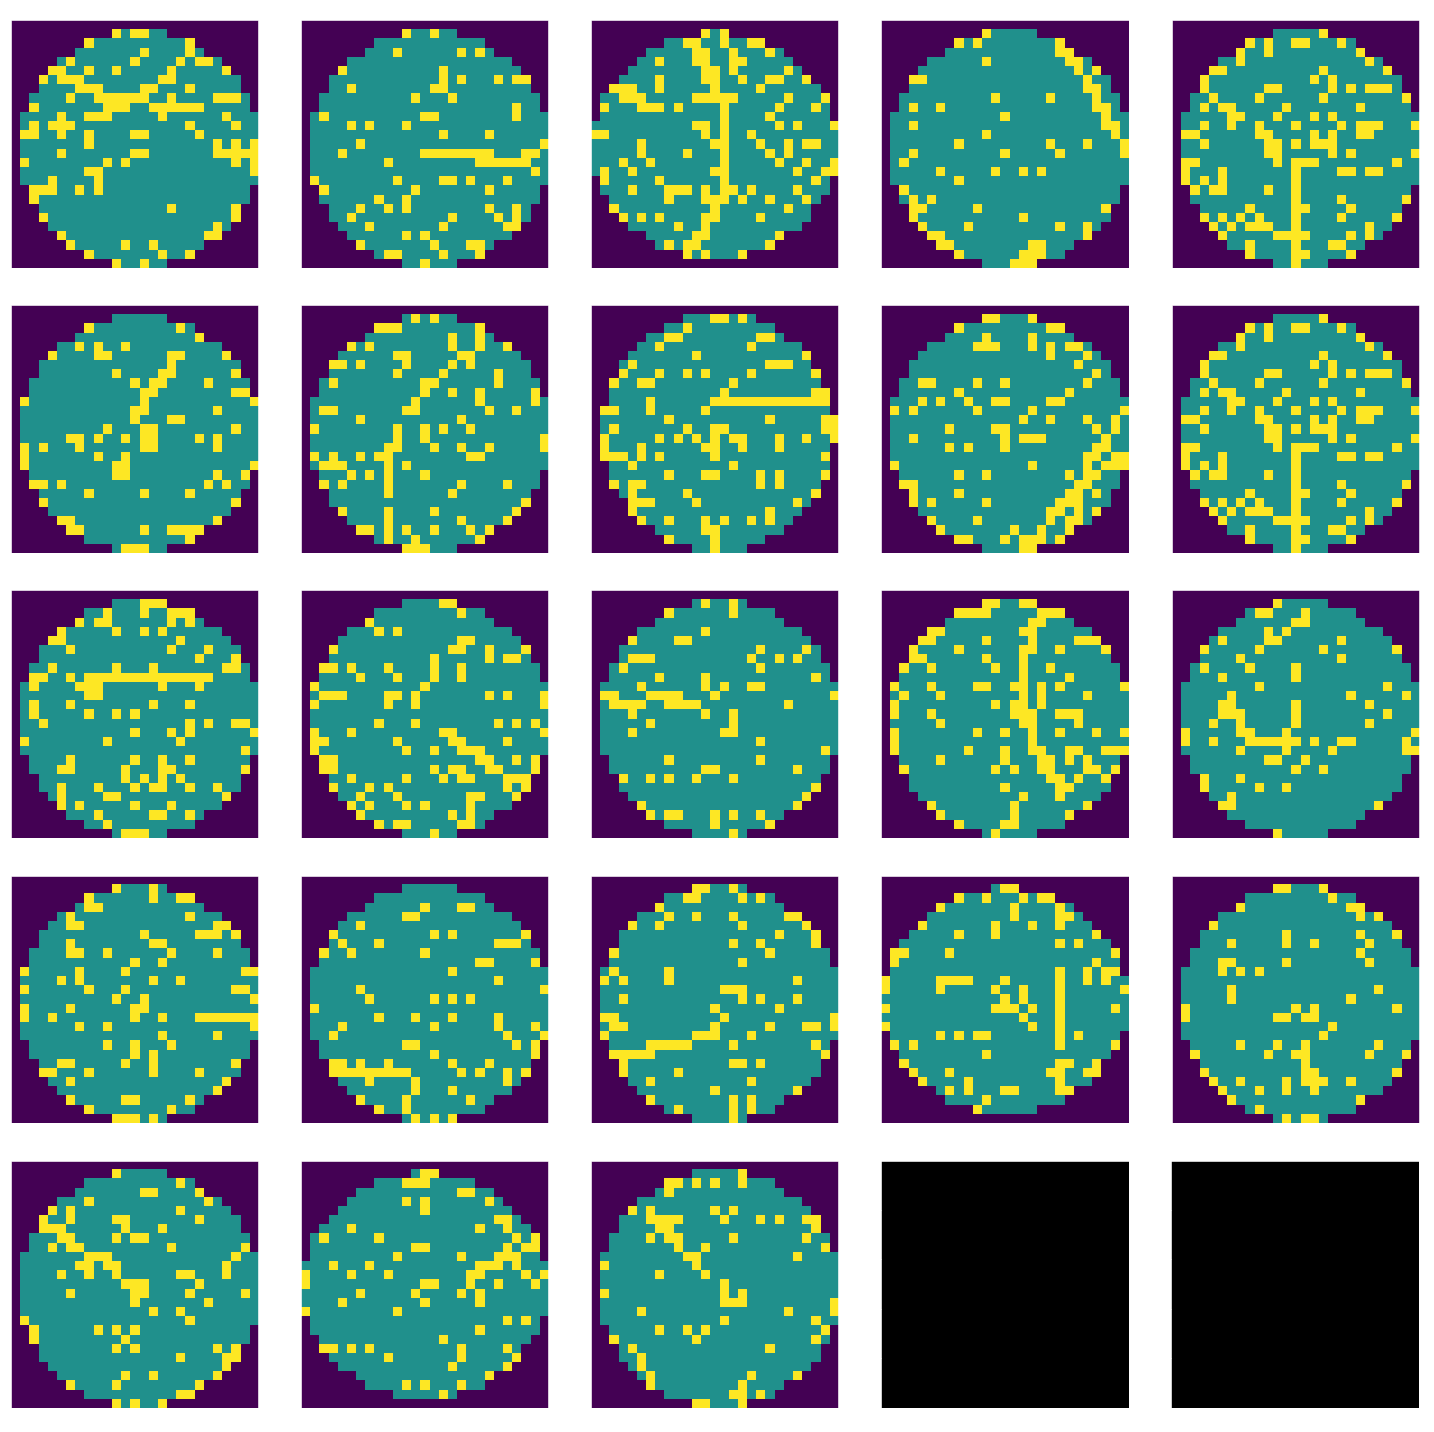

In [533]:
#Draw misclassified image
#Scratch
cnt = 0
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(mis_index[0])):
        if faulty_case[int(y_test_decode[mis_index[0][i]])] == 'Scratch':
            img = px_test[mis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {}'.format(faulty_case[int(y_pred_decode[mis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(y_test_decode[mis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 25:
            break
plt.tight_layout()
plt.show() 

In [534]:
## Findings : mis labled? 
## Hard to classify? Both are correct?

In [535]:
## F1 Score
## Precision-Recall Curve?

In [536]:
for i in range (len(mis_index[0])):
    if faulty_case[int(y_test_decode[mis_index[0][i]])] == 'Donut':
        # plot Donut fault data
        plt.imshow(px_test[mis_index[0][i]])
        plt.title('Predicted: {}, Labeled: {}'.format(faulty_case[int(y_pred_decode[mis_index[0][i]])], faulty_case[int(y_test_decode[mis_index[0][i]])]) )
        plt.show()